In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N24_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 25
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 24


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/measure_3D/N24_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 640_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 9.494666337966919 sec.


  0%|                                                                                                                                    | 0/800 [00:00<?, ?it/s]

  2%|██▊                                                                                                                        | 18/800 [00:10<07:31,  1.73it/s]

  7%|████████▉                                                                                                                  | 58/800 [00:10<01:44,  7.11it/s]

 12%|███████████████                                                                                                            | 98/800 [00:20<02:22,  4.92it/s]

 14%|████████████████▍                                                                                                         | 108/800 [00:21<01:59,  5.77it/s]

 16%|███████████████████▌                                                                                                      | 128/800 [00:21<01:21,  8.21it/s]

 21%|█████████████████████████▌                                                                                                | 168/800 [00:21<00:42, 14.87it/s]

 24%|████████████████████████████▋                                                                                             | 188/800 [00:31<01:49,  5.59it/s]

 27%|█████████████████████████████████▏                                                                                        | 218/800 [00:31<01:08,  8.46it/s]

 31%|█████████████████████████████████████▊                                                                                    | 248/800 [00:32<00:45, 12.06it/s]

 34%|████████████████████████████████████████▊                                                                                 | 268/800 [00:42<01:38,  5.42it/s]

 35%|██████████████████████████████████████████▍                                                                               | 278/800 [00:42<01:22,  6.30it/s]

 40%|████████████████████████████████████████████████▍                                                                         | 318/800 [00:42<00:42, 11.22it/s]

 42%|███████████████████████████████████████████████████▌                                                                      | 338/800 [00:52<01:25,  5.39it/s]

 44%|█████████████████████████████████████████████████████                                                                     | 348/800 [00:52<01:14,  6.06it/s]

 45%|██████████████████████████████████████████████████████▌                                                                   | 358/800 [00:53<01:02,  7.08it/s]

 48%|███████████████████████████████████████████████████████████▏                                                              | 388/800 [00:53<00:34, 12.03it/s]

 51%|██████████████████████████████████████████████████████████████▏                                                           | 408/800 [00:53<00:23, 16.45it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                        | 428/800 [01:03<01:09,  5.32it/s]

 55%|██████████████████████████████████████████████████████████████████▊                                                       | 438/800 [01:03<00:59,  6.12it/s]

 57%|█████████████████████████████████████████████████████████████████████▊                                                    | 458/800 [01:03<00:38,  8.92it/s]

 61%|██████████████████████████████████████████████████████████████████████████▍                                               | 488/800 [01:04<00:21, 14.71it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▍                                            | 508/800 [01:13<00:54,  5.34it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▉                                           | 518/800 [01:14<00:46,  6.05it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████                                        | 538/800 [01:14<00:29,  8.83it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▌                                      | 548/800 [01:14<00:23, 10.57it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                 | 578/800 [01:23<00:42,  5.23it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▋                                | 588/800 [01:24<00:35,  6.03it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                              | 598/800 [01:24<00:28,  7.02it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▏                           | 618/800 [01:25<00:17, 10.48it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 648/800 [01:25<00:08, 17.29it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 658/800 [01:34<00:28,  5.07it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 668/800 [01:34<00:22,  5.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 677/800 [01:35<00:17,  6.95it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 687/800 [01:35<00:13,  8.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 697/800 [01:35<00:09, 10.96it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 707/800 [01:35<00:06, 14.36it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 717/800 [01:35<00:04, 18.81it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 727/800 [01:35<00:02, 24.35it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 746/800 [01:36<00:01, 37.43it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 764/800 [01:36<00:01, 34.75it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 782/800 [01:36<00:00, 43.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:37<00:00, 46.45it/s]

Ran thermalisation program in: 107.0363495349884 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 5.0414325165639955 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [01:50<00:00, 46.45it/s]

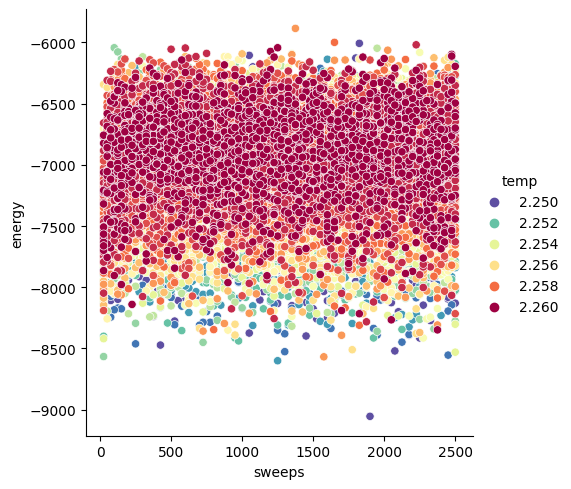

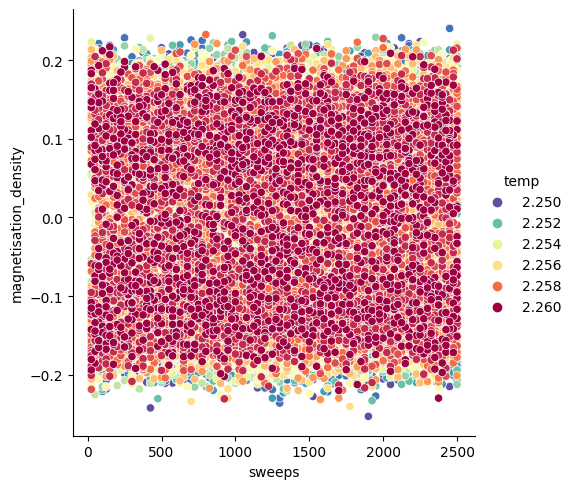

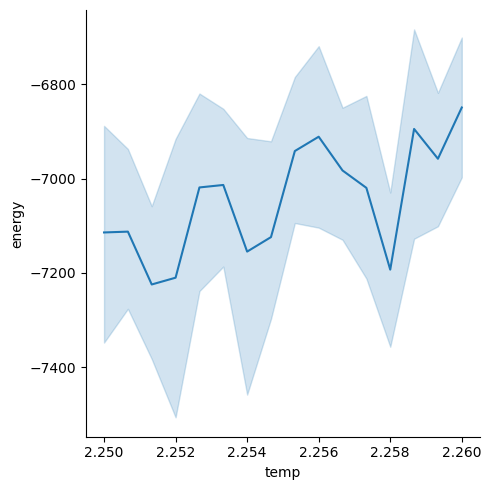

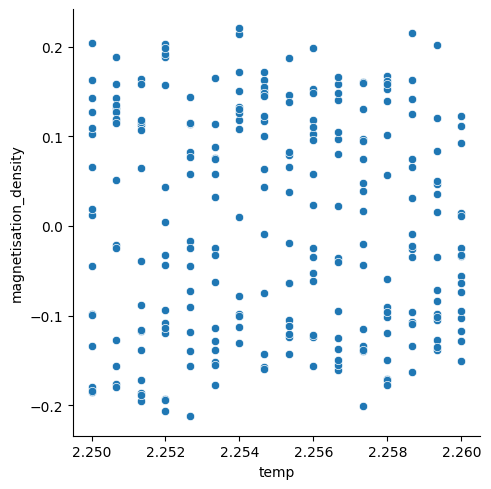

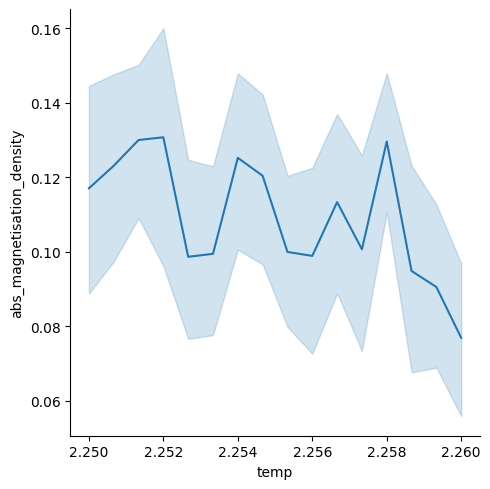

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

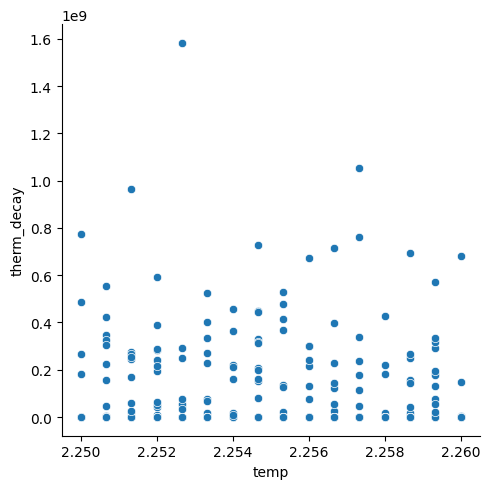

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        100,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                                                   | 0/8000 [00:00<?, ?it/s]

  0%|▎                                                                                                                         | 18/8000 [00:04<30:18,  4.39it/s]

  1%|▉                                                                                                                         | 58/8000 [00:04<07:37, 17.34it/s]

  1%|█▍                                                                                                                        | 98/8000 [00:08<10:31, 12.52it/s]

  1%|█▊                                                                                                                       | 118/8000 [00:08<07:50, 16.77it/s]

  2%|██▏                                                                                                                      | 148/8000 [00:08<05:14, 24.97it/s]

  2%|██▌                                                                                                                      | 168/8000 [00:08<04:04, 31.99it/s]

  2%|██▊                                                                                                                      | 188/8000 [00:12<09:55, 13.13it/s]

  3%|███▎                                                                                                                     | 218/8000 [00:12<06:27, 20.09it/s]

  3%|███▊                                                                                                                     | 248/8000 [00:13<04:47, 27.00it/s]

  3%|████                                                                                                                     | 268/8000 [00:16<09:32, 13.50it/s]

  4%|████▎                                                                                                                    | 288/8000 [00:17<07:13, 17.77it/s]

  4%|████▋                                                                                                                    | 308/8000 [00:17<05:27, 23.47it/s]

  4%|████▉                                                                                                                    | 328/8000 [00:17<04:31, 28.30it/s]

  4%|█████▎                                                                                                                   | 348/8000 [00:21<09:47, 13.03it/s]

  5%|█████▌                                                                                                                   | 368/8000 [00:21<07:19, 17.37it/s]

  5%|█████▋                                                                                                                   | 378/8000 [00:21<06:18, 20.15it/s]

  5%|██████                                                                                                                   | 398/8000 [00:21<04:48, 26.37it/s]

  5%|██████▎                                                                                                                  | 418/8000 [00:25<10:30, 12.02it/s]

  6%|██████▊                                                                                                                  | 448/8000 [00:25<06:30, 19.32it/s]

  6%|██████▉                                                                                                                  | 458/8000 [00:25<06:00, 20.93it/s]

  6%|███████▏                                                                                                                 | 478/8000 [00:25<04:29, 27.93it/s]

  6%|███████▍                                                                                                                 | 488/8000 [00:26<04:12, 29.78it/s]

  6%|███████▌                                                                                                                 | 498/8000 [00:29<12:09, 10.28it/s]

  7%|████████▏                                                                                                                | 538/8000 [00:29<06:10, 20.14it/s]

  7%|████████▍                                                                                                                | 558/8000 [00:30<04:55, 25.21it/s]

  7%|████████▌                                                                                                                | 568/8000 [00:30<04:41, 26.44it/s]

  7%|████████▋                                                                                                                | 578/8000 [00:33<11:31, 10.74it/s]

  7%|█████████                                                                                                                | 598/8000 [00:33<07:39, 16.12it/s]

  8%|█████████▎                                                                                                               | 618/8000 [00:34<05:35, 22.00it/s]

  8%|█████████▋                                                                                                               | 638/8000 [00:34<04:28, 27.44it/s]

  8%|█████████▊                                                                                                               | 648/8000 [00:34<04:21, 28.11it/s]

  8%|█████████▉                                                                                                               | 658/8000 [00:38<11:47, 10.38it/s]

  8%|██████████▎                                                                                                              | 678/8000 [00:38<07:38, 15.96it/s]

  9%|██████████▌                                                                                                              | 698/8000 [00:38<05:28, 22.21it/s]

  9%|██████████▊                                                                                                              | 718/8000 [00:38<04:24, 27.51it/s]

  9%|███████████                                                                                                              | 728/8000 [00:39<04:31, 26.76it/s]

  9%|███████████▏                                                                                                             | 738/8000 [00:42<11:16, 10.74it/s]

  9%|███████████▍                                                                                                             | 758/8000 [00:42<07:38, 15.78it/s]

 10%|███████████▊                                                                                                             | 778/8000 [00:42<05:29, 21.92it/s]

 10%|████████████                                                                                                             | 798/8000 [00:42<04:13, 28.43it/s]

 10%|████████████▏                                                                                                            | 808/8000 [00:43<04:33, 26.30it/s]

 10%|████████████▎                                                                                                            | 818/8000 [00:46<10:55, 10.95it/s]

 10%|████████████▋                                                                                                            | 838/8000 [00:46<07:29, 15.92it/s]

 11%|████████████▉                                                                                                            | 858/8000 [00:46<05:28, 21.76it/s]

 11%|█████████████▎                                                                                                           | 878/8000 [00:47<04:18, 27.50it/s]

 11%|█████████████▍                                                                                                           | 888/8000 [00:47<04:48, 24.68it/s]

 11%|█████████████▌                                                                                                           | 898/8000 [00:50<10:47, 10.97it/s]

 11%|█████████████▋                                                                                                           | 908/8000 [00:50<08:31, 13.87it/s]

 12%|██████████████                                                                                                           | 928/8000 [00:50<05:27, 21.57it/s]

 12%|██████████████▏                                                                                                          | 938/8000 [00:51<05:06, 23.03it/s]

 12%|██████████████▍                                                                                                          | 958/8000 [00:51<03:56, 29.77it/s]

 12%|██████████████▋                                                                                                          | 968/8000 [00:52<04:54, 23.84it/s]

 12%|██████████████▊                                                                                                          | 978/8000 [00:54<10:48, 10.82it/s]

 12%|██████████████▉                                                                                                          | 988/8000 [00:54<08:24, 13.91it/s]

 12%|███████████████                                                                                                          | 998/8000 [00:55<06:29, 17.96it/s]

 13%|███████████████▎                                                                                                        | 1018/8000 [00:55<04:56, 23.52it/s]

 13%|███████████████▌                                                                                                        | 1038/8000 [00:55<03:30, 33.13it/s]

 13%|███████████████▋                                                                                                        | 1048/8000 [00:56<04:52, 23.74it/s]

 13%|███████████████▊                                                                                                        | 1058/8000 [00:59<10:27, 11.07it/s]

 13%|████████████████▏                                                                                                       | 1078/8000 [00:59<06:43, 17.17it/s]

 14%|████████████████▍                                                                                                       | 1098/8000 [00:59<05:08, 22.35it/s]

 14%|████████████████▌                                                                                                       | 1108/8000 [00:59<04:29, 25.56it/s]

 14%|████████████████▊                                                                                                       | 1118/8000 [01:00<03:51, 29.73it/s]

 14%|████████████████▉                                                                                                       | 1128/8000 [01:00<05:22, 21.31it/s]

 14%|█████████████████                                                                                                       | 1138/8000 [01:03<11:06, 10.30it/s]

 14%|█████████████████▏                                                                                                      | 1148/8000 [01:03<08:41, 13.14it/s]

 15%|█████████████████▋                                                                                                      | 1178/8000 [01:04<05:03, 22.47it/s]

 15%|█████████████████▊                                                                                                      | 1188/8000 [01:04<04:23, 25.88it/s]

 15%|█████████████████▉                                                                                                      | 1198/8000 [01:04<03:50, 29.48it/s]

 15%|██████████████████                                                                                                      | 1208/8000 [01:05<05:23, 20.97it/s]

 15%|██████████████████▎                                                                                                     | 1218/8000 [01:07<10:13, 11.05it/s]

 15%|██████████████████▍                                                                                                     | 1228/8000 [01:07<08:19, 13.55it/s]

 16%|██████████████████▊                                                                                                     | 1258/8000 [01:08<05:10, 21.70it/s]

 16%|███████████████████                                                                                                     | 1268/8000 [01:08<04:26, 25.25it/s]

 16%|███████████████████▎                                                                                                    | 1288/8000 [01:09<05:11, 21.55it/s]

 16%|███████████████████▍                                                                                                    | 1298/8000 [01:11<08:27, 13.22it/s]

 16%|███████████████████▌                                                                                                    | 1308/8000 [01:11<07:08, 15.62it/s]

 16%|███████████████████▊                                                                                                    | 1318/8000 [01:12<05:54, 18.84it/s]

 17%|████████████████████                                                                                                    | 1338/8000 [01:12<04:53, 22.73it/s]

 17%|████████████████████▏                                                                                                   | 1348/8000 [01:12<04:26, 24.97it/s]

 17%|████████████████████▌                                                                                                   | 1368/8000 [01:14<05:06, 21.62it/s]

 17%|████████████████████▋                                                                                                   | 1378/8000 [01:15<08:07, 13.58it/s]

 17%|████████████████████▊                                                                                                   | 1388/8000 [01:16<06:55, 15.93it/s]

 17%|████████████████████▉                                                                                                   | 1398/8000 [01:16<05:50, 18.85it/s]

 18%|█████████████████████                                                                                                   | 1408/8000 [01:16<04:40, 23.47it/s]

 18%|█████████████████████▎                                                                                                  | 1418/8000 [01:17<05:15, 20.89it/s]

 18%|█████████████████████▍                                                                                                  | 1428/8000 [01:17<04:09, 26.33it/s]

 18%|█████████████████████▋                                                                                                  | 1448/8000 [01:18<05:10, 21.12it/s]

 18%|█████████████████████▊                                                                                                  | 1458/8000 [01:19<08:05, 13.48it/s]

 18%|██████████████████████                                                                                                  | 1468/8000 [01:20<07:20, 14.84it/s]

 18%|██████████████████████▏                                                                                                 | 1478/8000 [01:20<05:47, 18.77it/s]

 19%|██████████████████████▎                                                                                                 | 1488/8000 [01:20<04:52, 22.23it/s]

 19%|██████████████████████▍                                                                                                 | 1498/8000 [01:21<05:12, 20.80it/s]

 19%|██████████████████████▊                                                                                                 | 1518/8000 [01:21<03:23, 31.87it/s]

 19%|██████████████████████▉                                                                                                 | 1528/8000 [01:22<05:38, 19.11it/s]

 19%|███████████████████████                                                                                                 | 1538/8000 [01:24<08:08, 13.22it/s]

 19%|███████████████████████▏                                                                                                | 1548/8000 [01:24<07:09, 15.04it/s]

 19%|███████████████████████▎                                                                                                | 1558/8000 [01:24<06:20, 16.93it/s]

 20%|███████████████████████▋                                                                                                | 1578/8000 [01:25<04:58, 21.55it/s]

 20%|███████████████████████▉                                                                                                | 1598/8000 [01:25<03:32, 30.09it/s]

 20%|████████████████████████                                                                                                | 1608/8000 [01:27<05:40, 18.76it/s]

 20%|████████████████████████▎                                                                                               | 1618/8000 [01:28<07:16, 14.62it/s]

 20%|████████████████████████▍                                                                                               | 1628/8000 [01:28<07:01, 15.11it/s]

 20%|████████████████████████▌                                                                                               | 1638/8000 [01:29<06:23, 16.59it/s]

 21%|████████████████████████▊                                                                                               | 1658/8000 [01:29<04:56, 21.41it/s]

 21%|█████████████████████████▏                                                                                              | 1678/8000 [01:30<03:29, 30.12it/s]

 21%|█████████████████████████▎                                                                                              | 1688/8000 [01:31<05:54, 17.80it/s]

 21%|█████████████████████████▍                                                                                              | 1698/8000 [01:32<07:08, 14.70it/s]

 21%|█████████████████████████▌                                                                                              | 1708/8000 [01:33<06:41, 15.66it/s]

 21%|█████████████████████████▊                                                                                              | 1718/8000 [01:33<06:21, 16.45it/s]

 22%|██████████████████████████                                                                                              | 1738/8000 [01:34<04:46, 21.82it/s]

 22%|██████████████████████████▎                                                                                             | 1758/8000 [01:34<03:24, 30.46it/s]

 22%|██████████████████████████▌                                                                                             | 1768/8000 [01:35<05:35, 18.60it/s]

 22%|██████████████████████████▋                                                                                             | 1778/8000 [01:36<07:10, 14.44it/s]

 22%|██████████████████████████▊                                                                                             | 1788/8000 [01:37<06:43, 15.40it/s]

 22%|██████████████████████████▉                                                                                             | 1798/8000 [01:37<06:16, 16.45it/s]

 23%|███████████████████████████▎                                                                                            | 1818/8000 [01:38<04:51, 21.17it/s]

 23%|███████████████████████████▍                                                                                            | 1828/8000 [01:38<03:58, 25.86it/s]

 23%|███████████████████████████▋                                                                                            | 1848/8000 [01:39<05:07, 20.02it/s]

 23%|███████████████████████████▊                                                                                            | 1858/8000 [01:41<06:43, 15.23it/s]

 23%|████████████████████████████                                                                                            | 1868/8000 [01:41<06:09, 16.58it/s]

 23%|████████████████████████████▏                                                                                           | 1878/8000 [01:42<05:51, 17.41it/s]

 24%|████████████████████████████▎                                                                                           | 1888/8000 [01:42<04:34, 22.26it/s]

 24%|████████████████████████████▍                                                                                           | 1898/8000 [01:42<05:17, 19.24it/s]

 24%|████████████████████████████▉                                                                                           | 1928/8000 [01:44<04:58, 20.31it/s]

 24%|█████████████████████████████                                                                                           | 1938/8000 [01:45<06:08, 16.46it/s]

 24%|█████████████████████████████▏                                                                                          | 1948/8000 [01:45<06:10, 16.35it/s]

 24%|█████████████████████████████▎                                                                                          | 1958/8000 [01:46<05:36, 17.93it/s]

 25%|█████████████████████████████▋                                                                                          | 1978/8000 [01:47<04:53, 20.51it/s]

 25%|█████████████████████████████▉                                                                                          | 1998/8000 [01:47<03:16, 30.55it/s]

 25%|██████████████████████████████                                                                                          | 2008/8000 [01:48<05:21, 18.63it/s]

 25%|██████████████████████████████▎                                                                                         | 2018/8000 [01:49<06:31, 15.26it/s]

 25%|██████████████████████████████▍                                                                                         | 2028/8000 [01:50<06:23, 15.57it/s]

 25%|██████████████████████████████▌                                                                                         | 2038/8000 [01:50<05:37, 17.66it/s]

 26%|██████████████████████████████▊                                                                                         | 2058/8000 [01:51<04:57, 19.99it/s]

 26%|███████████████████████████████                                                                                         | 2068/8000 [01:51<04:04, 24.25it/s]

 26%|███████████████████████████████▎                                                                                        | 2088/8000 [01:52<05:12, 18.91it/s]

 26%|███████████████████████████████▍                                                                                        | 2098/8000 [01:53<05:47, 17.00it/s]

 26%|███████████████████████████████▌                                                                                        | 2108/8000 [01:54<05:58, 16.42it/s]

 26%|███████████████████████████████▊                                                                                        | 2118/8000 [01:54<05:29, 17.86it/s]

 27%|████████████████████████████████                                                                                        | 2138/8000 [01:55<04:40, 20.93it/s]

 27%|████████████████████████████████▏                                                                                       | 2148/8000 [01:55<04:08, 23.51it/s]

 27%|████████████████████████████████▎                                                                                       | 2158/8000 [01:55<03:21, 28.94it/s]

 27%|████████████████████████████████▌                                                                                       | 2168/8000 [01:57<06:02, 16.10it/s]

 27%|████████████████████████████████▋                                                                                       | 2178/8000 [01:57<06:14, 15.56it/s]

 27%|████████████████████████████████▊                                                                                       | 2188/8000 [01:58<06:02, 16.03it/s]

 27%|████████████████████████████████▉                                                                                       | 2198/8000 [01:58<05:29, 17.61it/s]

 28%|█████████████████████████████████▎                                                                                      | 2218/8000 [01:59<04:49, 19.97it/s]

 28%|█████████████████████████████████▍                                                                                      | 2228/8000 [02:00<04:14, 22.64it/s]

 28%|█████████████████████████████████▋                                                                                      | 2248/8000 [02:01<05:41, 16.85it/s]

 28%|█████████████████████████████████▊                                                                                      | 2258/8000 [02:02<05:20, 17.92it/s]

 28%|██████████████████████████████████                                                                                      | 2268/8000 [02:02<05:42, 16.73it/s]

 28%|██████████████████████████████████▏                                                                                     | 2278/8000 [02:03<05:02, 18.90it/s]

 29%|██████████████████████████████████▎                                                                                     | 2288/8000 [02:03<04:16, 22.24it/s]

 29%|██████████████████████████████████▍                                                                                     | 2298/8000 [02:03<04:31, 21.02it/s]

 29%|██████████████████████████████████▌                                                                                     | 2308/8000 [02:04<04:26, 21.37it/s]

 29%|██████████████████████████████████▉                                                                                     | 2328/8000 [02:05<05:46, 16.37it/s]

 29%|███████████████████████████████████                                                                                     | 2338/8000 [02:06<05:17, 17.85it/s]

 29%|███████████████████████████████████▏                                                                                    | 2348/8000 [02:07<05:34, 16.91it/s]

 29%|███████████████████████████████████▎                                                                                    | 2358/8000 [02:07<04:56, 19.06it/s]

 30%|███████████████████████████████████▌                                                                                    | 2368/8000 [02:07<04:09, 22.58it/s]

 30%|███████████████████████████████████▋                                                                                    | 2378/8000 [02:08<04:49, 19.44it/s]

 30%|███████████████████████████████████▊                                                                                    | 2388/8000 [02:08<04:29, 20.83it/s]

 30%|████████████████████████████████████                                                                                    | 2408/8000 [02:10<05:46, 16.12it/s]

 30%|████████████████████████████████████▎                                                                                   | 2418/8000 [02:10<05:10, 17.98it/s]

 30%|████████████████████████████████████▍                                                                                   | 2428/8000 [02:11<05:15, 17.68it/s]

 30%|████████████████████████████████████▌                                                                                   | 2438/8000 [02:11<04:34, 20.27it/s]

 31%|████████████████████████████████████▋                                                                                   | 2448/8000 [02:11<04:07, 22.40it/s]

 31%|████████████████████████████████████▊                                                                                   | 2458/8000 [02:12<04:51, 19.02it/s]

 31%|█████████████████████████████████████                                                                                   | 2468/8000 [02:13<04:44, 19.45it/s]

 31%|█████████████████████████████████████▎                                                                                  | 2488/8000 [02:14<05:50, 15.74it/s]

 31%|█████████████████████████████████████▍                                                                                  | 2498/8000 [02:14<04:57, 18.51it/s]

 31%|█████████████████████████████████████▌                                                                                  | 2508/8000 [02:15<05:06, 17.92it/s]

 31%|█████████████████████████████████████▊                                                                                  | 2518/8000 [02:15<04:41, 19.50it/s]

 32%|█████████████████████████████████████▉                                                                                  | 2528/8000 [02:16<04:30, 20.25it/s]

 32%|██████████████████████████████████████                                                                                  | 2538/8000 [02:16<04:44, 19.20it/s]

 32%|██████████████████████████████████████▏                                                                                 | 2548/8000 [02:17<04:19, 21.04it/s]

 32%|██████████████████████████████████████▌                                                                                 | 2568/8000 [02:18<05:44, 15.75it/s]

 32%|██████████████████████████████████████▋                                                                                 | 2578/8000 [02:19<04:57, 18.24it/s]

 32%|██████████████████████████████████████▊                                                                                 | 2588/8000 [02:19<04:43, 19.07it/s]

 32%|██████████████████████████████████████▉                                                                                 | 2598/8000 [02:20<04:38, 19.41it/s]

 33%|███████████████████████████████████████                                                                                 | 2608/8000 [02:20<04:49, 18.66it/s]

 33%|███████████████████████████████████████▎                                                                                | 2618/8000 [02:21<04:39, 19.24it/s]

 33%|███████████████████████████████████████▍                                                                                | 2628/8000 [02:21<04:15, 21.05it/s]

 33%|███████████████████████████████████████▋                                                                                | 2648/8000 [02:23<05:36, 15.90it/s]

 33%|████████████████████████████████████████                                                                                | 2668/8000 [02:23<04:32, 19.58it/s]

 33%|████████████████████████████████████████▏                                                                               | 2678/8000 [02:24<04:33, 19.46it/s]

 34%|████████████████████████████████████████▎                                                                               | 2688/8000 [02:25<04:46, 18.57it/s]

 34%|████████████████████████████████████████▍                                                                               | 2698/8000 [02:25<04:32, 19.43it/s]

 34%|████████████████████████████████████████▌                                                                               | 2708/8000 [02:25<04:19, 20.41it/s]

 34%|████████████████████████████████████████▊                                                                               | 2718/8000 [02:26<03:22, 26.08it/s]

 34%|████████████████████████████████████████▉                                                                               | 2728/8000 [02:27<06:16, 14.02it/s]

 34%|█████████████████████████████████████████▏                                                                              | 2748/8000 [02:28<04:45, 18.41it/s]

 34%|█████████████████████████████████████████▎                                                                              | 2758/8000 [02:28<04:30, 19.36it/s]

 35%|█████████████████████████████████████████▌                                                                              | 2768/8000 [02:29<04:50, 18.03it/s]

 35%|█████████████████████████████████████████▋                                                                              | 2778/8000 [02:29<04:27, 19.55it/s]

 35%|█████████████████████████████████████████▊                                                                              | 2788/8000 [02:30<04:25, 19.62it/s]

 35%|██████████████████████████████████████████                                                                              | 2808/8000 [02:31<05:28, 15.80it/s]

 35%|██████████████████████████████████████████▎                                                                             | 2818/8000 [02:31<04:31, 19.06it/s]

 35%|██████████████████████████████████████████▍                                                                             | 2828/8000 [02:32<04:26, 19.38it/s]

 35%|██████████████████████████████████████████▌                                                                             | 2838/8000 [02:32<04:25, 19.45it/s]

 36%|██████████████████████████████████████████▋                                                                             | 2848/8000 [02:33<04:42, 18.25it/s]

 36%|██████████████████████████████████████████▊                                                                             | 2858/8000 [02:34<04:23, 19.49it/s]

 36%|███████████████████████████████████████████                                                                             | 2868/8000 [02:34<04:16, 20.00it/s]

 36%|███████████████████████████████████████████▎                                                                            | 2888/8000 [02:36<05:21, 15.92it/s]

 36%|███████████████████████████████████████████▍                                                                            | 2898/8000 [02:36<04:35, 18.50it/s]

 36%|███████████████████████████████████████████▌                                                                            | 2908/8000 [02:36<04:15, 19.90it/s]

 36%|███████████████████████████████████████████▊                                                                            | 2918/8000 [02:37<04:03, 20.90it/s]

 37%|███████████████████████████████████████████▉                                                                            | 2928/8000 [02:37<04:46, 17.71it/s]

 37%|████████████████████████████████████████████                                                                            | 2938/8000 [02:38<04:25, 19.03it/s]

 37%|████████████████████████████████████████████▏                                                                           | 2948/8000 [02:38<04:16, 19.71it/s]

 37%|████████████████████████████████████████████▌                                                                           | 2968/8000 [02:40<05:04, 16.55it/s]

 37%|████████████████████████████████████████████▋                                                                           | 2978/8000 [02:40<04:32, 18.43it/s]

 37%|████████████████████████████████████████████▊                                                                           | 2988/8000 [02:40<03:45, 22.26it/s]

 37%|████████████████████████████████████████████▉                                                                           | 2998/8000 [02:41<04:08, 20.17it/s]

 38%|█████████████████████████████████████████████                                                                           | 3008/8000 [02:42<04:45, 17.47it/s]

 38%|█████████████████████████████████████████████▎                                                                          | 3018/8000 [02:42<04:24, 18.82it/s]

 38%|█████████████████████████████████████████████▍                                                                          | 3028/8000 [02:43<04:11, 19.80it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 3038/8000 [02:43<03:13, 25.60it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 3048/8000 [02:44<05:07, 16.08it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 3058/8000 [02:44<04:59, 16.49it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 3078/8000 [02:45<04:12, 19.46it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 3088/8000 [02:46<04:29, 18.23it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 3098/8000 [02:46<04:19, 18.87it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 3108/8000 [02:47<04:04, 19.97it/s]

 39%|██████████████████████████████████████████████▊                                                                         | 3118/8000 [02:47<03:19, 24.47it/s]

 39%|██████████████████████████████████████████████▉                                                                         | 3128/8000 [02:48<04:59, 16.27it/s]

 39%|███████████████████████████████████████████████                                                                         | 3138/8000 [02:49<04:36, 17.57it/s]

 39%|███████████████████████████████████████████████▏                                                                        | 3148/8000 [02:49<03:54, 20.72it/s]

 39%|███████████████████████████████████████████████▎                                                                        | 3158/8000 [02:49<04:10, 19.31it/s]

 40%|███████████████████████████████████████████████▌                                                                        | 3168/8000 [02:50<04:50, 16.63it/s]

 40%|███████████████████████████████████████████████▋                                                                        | 3178/8000 [02:51<04:15, 18.90it/s]

 40%|███████████████████████████████████████████████▊                                                                        | 3188/8000 [02:51<03:56, 20.34it/s]

 40%|███████████████████████████████████████████████▉                                                                        | 3198/8000 [02:51<03:13, 24.85it/s]

 40%|████████████████████████████████████████████████                                                                        | 3208/8000 [02:52<04:41, 17.04it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 3218/8000 [02:53<04:54, 16.26it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 3228/8000 [02:53<04:08, 19.17it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 3238/8000 [02:54<04:16, 18.53it/s]

 41%|████████████████████████████████████████████████▋                                                                       | 3248/8000 [02:55<04:58, 15.93it/s]

 41%|████████████████████████████████████████████████▊                                                                       | 3258/8000 [02:55<03:51, 20.45it/s]

 41%|█████████████████████████████████████████████████                                                                       | 3268/8000 [02:55<03:48, 20.68it/s]

 41%|█████████████████████████████████████████████████▏                                                                      | 3278/8000 [02:55<02:57, 26.57it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 3288/8000 [02:56<04:35, 17.13it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 3298/8000 [02:57<04:31, 17.30it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 3308/8000 [02:57<04:15, 18.40it/s]

 41%|█████████████████████████████████████████████████▊                                                                      | 3318/8000 [02:58<04:29, 17.40it/s]

 42%|█████████████████████████████████████████████████▉                                                                      | 3328/8000 [02:59<05:02, 15.46it/s]

 42%|██████████████████████████████████████████████████                                                                      | 3338/8000 [02:59<04:03, 19.15it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 3348/8000 [03:00<03:38, 21.32it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 3358/8000 [03:00<02:47, 27.64it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 3368/8000 [03:01<04:29, 17.16it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 3378/8000 [03:01<04:14, 18.18it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 3388/8000 [03:02<04:20, 17.68it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 3398/8000 [03:02<04:23, 17.48it/s]

 43%|███████████████████████████████████████████████████                                                                     | 3408/8000 [03:03<04:47, 15.99it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 3418/8000 [03:03<04:02, 18.92it/s]

 43%|███████████████████████████████████████████████████▍                                                                    | 3428/8000 [03:04<03:40, 20.75it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 3438/8000 [03:04<03:07, 24.32it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 3448/8000 [03:05<03:54, 19.39it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 3458/8000 [03:06<04:19, 17.52it/s]

 43%|████████████████████████████████████████████████████                                                                    | 3468/8000 [03:06<04:17, 17.60it/s]

 43%|████████████████████████████████████████████████████▏                                                                   | 3478/8000 [03:07<03:59, 18.90it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 3488/8000 [03:07<04:47, 15.69it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 3498/8000 [03:08<04:07, 18.19it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 3508/8000 [03:08<03:38, 20.52it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 3518/8000 [03:08<03:09, 23.70it/s]

 44%|████████████████████████████████████████████████████▉                                                                   | 3528/8000 [03:09<03:34, 20.84it/s]

 44%|█████████████████████████████████████████████████████                                                                   | 3538/8000 [03:10<04:23, 16.92it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 3548/8000 [03:10<04:29, 16.53it/s]

 44%|█████████████████████████████████████████████████████▎                                                                  | 3558/8000 [03:11<03:55, 18.89it/s]

 45%|█████████████████████████████████████████████████████▌                                                                  | 3568/8000 [03:12<04:31, 16.34it/s]

 45%|█████████████████████████████████████████████████████▋                                                                  | 3578/8000 [03:12<03:42, 19.85it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 3588/8000 [03:12<03:21, 21.84it/s]

 45%|█████████████████████████████████████████████████████▉                                                                  | 3598/8000 [03:13<03:29, 20.99it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 3608/8000 [03:13<03:18, 22.08it/s]

 45%|██████████████████████████████████████████████████████▎                                                                 | 3618/8000 [03:14<04:18, 16.93it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 3628/8000 [03:15<04:26, 16.43it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 3638/8000 [03:15<03:43, 19.51it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 3648/8000 [03:16<04:23, 16.51it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 3658/8000 [03:16<03:44, 19.31it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 3668/8000 [03:16<03:24, 21.22it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 3678/8000 [03:17<03:46, 19.09it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 3688/8000 [03:17<03:07, 23.01it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 3698/8000 [03:18<04:20, 16.51it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 3708/8000 [03:19<04:38, 15.39it/s]

 46%|███████████████████████████████████████████████████████▊                                                                | 3718/8000 [03:19<03:31, 20.27it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 3728/8000 [03:20<04:03, 17.54it/s]

 47%|████████████████████████████████████████████████████████                                                                | 3738/8000 [03:20<03:27, 20.57it/s]

 47%|████████████████████████████████████████████████████████▏                                                               | 3748/8000 [03:21<03:25, 20.69it/s]

 47%|████████████████████████████████████████████████████████▎                                                               | 3758/8000 [03:21<03:44, 18.87it/s]

 47%|████████████████████████████████████████████████████████▌                                                               | 3768/8000 [03:22<02:54, 24.20it/s]

 47%|████████████████████████████████████████████████████████▋                                                               | 3778/8000 [03:23<04:08, 17.02it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 3788/8000 [03:23<04:43, 14.85it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 3808/8000 [03:24<03:55, 17.81it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 3818/8000 [03:25<03:28, 20.08it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 3828/8000 [03:25<03:17, 21.11it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 3838/8000 [03:26<03:45, 18.42it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 3858/8000 [03:27<03:34, 19.27it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 3868/8000 [03:28<04:20, 15.87it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 3888/8000 [03:29<03:46, 18.16it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 3898/8000 [03:29<03:18, 20.72it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 3908/8000 [03:29<03:27, 19.70it/s]

 49%|██████████████████████████████████████████████████████████▊                                                             | 3918/8000 [03:30<03:42, 18.33it/s]

 49%|███████████████████████████████████████████████████████████                                                             | 3938/8000 [03:31<03:18, 20.43it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 3948/8000 [03:32<04:20, 15.56it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 3968/8000 [03:33<03:36, 18.62it/s]

 50%|███████████████████████████████████████████████████████████▋                                                            | 3978/8000 [03:33<03:07, 21.49it/s]

 50%|███████████████████████████████████████████████████████████▊                                                            | 3988/8000 [03:34<03:22, 19.78it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 3998/8000 [03:34<03:33, 18.72it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 4008/8000 [03:35<03:11, 20.83it/s]

 50%|████████████████████████████████████████████████████████████▎                                                           | 4018/8000 [03:35<03:34, 18.57it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 4028/8000 [03:36<04:27, 14.87it/s]

 51%|████████████████████████████████████████████████████████████▋                                                           | 4048/8000 [03:37<03:34, 18.42it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 4058/8000 [03:37<03:06, 21.18it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 4068/8000 [03:38<03:25, 19.12it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 4078/8000 [03:38<03:08, 20.81it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 4088/8000 [03:39<03:12, 20.29it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 4098/8000 [03:39<03:23, 19.19it/s]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 4108/8000 [03:40<04:19, 15.02it/s]

 51%|█████████████████████████████████████████████████████████████▊                                                          | 4118/8000 [03:41<03:20, 19.34it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 4128/8000 [03:41<03:28, 18.57it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 4138/8000 [03:42<03:12, 20.06it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 4148/8000 [03:42<03:23, 18.95it/s]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 4158/8000 [03:43<03:04, 20.82it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 4168/8000 [03:43<03:03, 20.86it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 4178/8000 [03:44<03:07, 20.44it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 4188/8000 [03:45<04:17, 14.78it/s]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 4198/8000 [03:45<03:25, 18.50it/s]

 53%|███████████████████████████████████████████████████████████████                                                         | 4208/8000 [03:45<03:31, 17.90it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 4218/8000 [03:46<03:15, 19.33it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 4228/8000 [03:47<03:27, 18.20it/s]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 4238/8000 [03:47<02:51, 21.94it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 4248/8000 [03:47<03:00, 20.75it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 4258/8000 [03:48<02:57, 21.07it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 4268/8000 [03:49<04:22, 14.21it/s]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 4278/8000 [03:49<03:32, 17.52it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 4288/8000 [03:50<03:20, 18.51it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 4298/8000 [03:50<02:56, 20.98it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 4308/8000 [03:51<03:33, 17.33it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 4318/8000 [03:51<02:46, 22.12it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 4328/8000 [03:52<03:03, 19.97it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 4338/8000 [03:52<02:46, 21.97it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 4348/8000 [03:53<04:13, 14.42it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 4358/8000 [03:54<03:37, 16.75it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 4368/8000 [03:54<03:18, 18.26it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 4378/8000 [03:54<02:45, 21.91it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 4388/8000 [03:55<03:31, 17.11it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 4398/8000 [03:55<02:42, 22.23it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 4408/8000 [03:56<03:03, 19.57it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 4418/8000 [03:56<03:02, 19.64it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 4428/8000 [03:57<03:44, 15.94it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 4438/8000 [03:58<03:32, 16.80it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 4448/8000 [03:58<03:26, 17.22it/s]

 56%|███████████████████████████████████████████████████████████████████                                                     | 4468/8000 [03:59<03:08, 18.74it/s]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 4478/8000 [04:00<02:42, 21.65it/s]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 4488/8000 [04:00<02:49, 20.67it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 4498/8000 [04:01<02:46, 21.09it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 4508/8000 [04:02<03:37, 16.09it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 4518/8000 [04:02<03:29, 16.60it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 4528/8000 [04:03<03:19, 17.37it/s]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 4548/8000 [04:04<02:59, 19.22it/s]

 57%|████████████████████████████████████████████████████████████████████▎                                                   | 4558/8000 [04:04<02:39, 21.63it/s]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 4568/8000 [04:04<02:44, 20.82it/s]

 57%|████████████████████████████████████████████████████████████████████▋                                                   | 4578/8000 [04:05<02:39, 21.45it/s]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 4588/8000 [04:06<03:29, 16.30it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 4598/8000 [04:07<03:50, 14.76it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 4608/8000 [04:07<03:02, 18.54it/s]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 4628/8000 [04:08<02:46, 20.25it/s]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 4638/8000 [04:08<02:41, 20.78it/s]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 4648/8000 [04:09<02:46, 20.09it/s]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 4658/8000 [04:09<02:21, 23.70it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 4668/8000 [04:10<03:29, 15.90it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 4678/8000 [04:11<03:44, 14.77it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 4688/8000 [04:11<02:53, 19.12it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 4708/8000 [04:12<02:43, 20.09it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 4718/8000 [04:13<02:43, 20.12it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 4728/8000 [04:13<02:43, 20.02it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 4738/8000 [04:13<02:11, 24.83it/s]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 4748/8000 [04:14<03:32, 15.28it/s]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 4758/8000 [04:15<03:40, 14.69it/s]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 4778/8000 [04:15<02:08, 25.00it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 4788/8000 [04:16<02:45, 19.39it/s]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 4798/8000 [04:17<02:56, 18.12it/s]

 60%|████████████████████████████████████████████████████████████████████████                                                | 4808/8000 [04:17<02:55, 18.20it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 4828/8000 [04:19<03:03, 17.29it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 4838/8000 [04:20<03:30, 15.01it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 4868/8000 [04:20<02:25, 21.49it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 4878/8000 [04:21<02:42, 19.22it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 4888/8000 [04:22<02:42, 19.18it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 4908/8000 [04:23<02:43, 18.95it/s]

 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 4918/8000 [04:24<03:21, 15.29it/s]

 62%|██████████████████████████████████████████████████████████████████████████▏                                             | 4948/8000 [04:25<02:19, 21.94it/s]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 4958/8000 [04:25<02:36, 19.44it/s]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 4968/8000 [04:26<02:42, 18.68it/s]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 4988/8000 [04:27<02:42, 18.48it/s]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 4998/8000 [04:28<03:13, 15.54it/s]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 5008/8000 [04:28<02:36, 19.14it/s]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 5018/8000 [04:28<02:05, 23.80it/s]

 63%|███████████████████████████████████████████████████████████████████████████▍                                            | 5028/8000 [04:29<02:10, 22.71it/s]

 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 5038/8000 [04:30<02:40, 18.50it/s]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 5048/8000 [04:30<02:50, 17.31it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 5068/8000 [04:31<02:39, 18.38it/s]

 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 5078/8000 [04:32<03:13, 15.09it/s]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 5088/8000 [04:32<02:31, 19.17it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 5098/8000 [04:33<02:00, 23.99it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 5108/8000 [04:33<01:56, 24.74it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 5118/8000 [04:34<02:41, 17.84it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 5128/8000 [04:35<02:53, 16.59it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 5148/8000 [04:36<02:32, 18.68it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 5158/8000 [04:37<03:12, 14.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 5178/8000 [04:37<02:06, 22.23it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 5188/8000 [04:37<01:53, 24.86it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 5198/8000 [04:38<02:35, 17.99it/s]

 65%|██████████████████████████████████████████████████████████████████████████████                                          | 5208/8000 [04:39<02:38, 17.57it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 5218/8000 [04:39<02:04, 22.26it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 5228/8000 [04:40<02:39, 17.37it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▌                                         | 5238/8000 [04:41<03:21, 13.72it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 5258/8000 [04:41<02:11, 20.83it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 5268/8000 [04:41<01:50, 24.73it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 5278/8000 [04:43<02:39, 17.06it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 5288/8000 [04:43<02:27, 18.34it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 5298/8000 [04:43<02:02, 22.13it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 5308/8000 [04:44<02:31, 17.77it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▊                                        | 5318/8000 [04:45<03:15, 13.74it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 5338/8000 [04:46<02:09, 20.53it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 5358/8000 [04:47<02:28, 17.85it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 5368/8000 [04:47<02:14, 19.57it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 5378/8000 [04:47<01:57, 22.31it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 5388/8000 [04:48<02:23, 18.25it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 5398/8000 [04:49<03:04, 14.11it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 5418/8000 [04:50<01:51, 23.25it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 5428/8000 [04:50<01:48, 23.70it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 5438/8000 [04:51<02:35, 16.48it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 5448/8000 [04:52<02:21, 18.01it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 5458/8000 [04:52<01:58, 21.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 5468/8000 [04:53<02:16, 18.55it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 5478/8000 [04:54<03:03, 13.76it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 5498/8000 [04:54<01:51, 22.52it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 5508/8000 [04:54<01:46, 23.49it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 5518/8000 [04:55<02:25, 17.05it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 5528/8000 [04:56<02:16, 18.07it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 5538/8000 [04:56<01:55, 21.26it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▏                                    | 5548/8000 [04:57<02:02, 20.09it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 5558/8000 [04:58<03:05, 13.17it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 5588/8000 [04:58<01:42, 23.47it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 5598/8000 [05:00<02:24, 16.65it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 5608/8000 [05:00<01:59, 19.96it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 5618/8000 [05:00<01:49, 21.76it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 5628/8000 [05:01<02:04, 19.07it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 5638/8000 [05:02<02:51, 13.80it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 5648/8000 [05:02<02:10, 18.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 5668/8000 [05:03<01:39, 23.32it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 5678/8000 [05:04<02:24, 16.03it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 5698/8000 [05:05<01:44, 22.00it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▌                                  | 5708/8000 [05:05<01:57, 19.49it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 5718/8000 [05:06<02:36, 14.62it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 5728/8000 [05:07<02:05, 18.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 5748/8000 [05:07<01:34, 23.92it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 5758/8000 [05:08<02:23, 15.59it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 5778/8000 [05:09<01:40, 22.20it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 5788/8000 [05:10<01:56, 19.00it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 5798/8000 [05:11<02:23, 15.35it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 5808/8000 [05:11<01:58, 18.44it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 5818/8000 [05:11<01:34, 23.21it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 5828/8000 [05:11<01:28, 24.60it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 5838/8000 [05:13<02:23, 15.02it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 5848/8000 [05:13<01:48, 19.89it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 5858/8000 [05:13<01:30, 23.65it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 5868/8000 [05:14<01:56, 18.28it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 5878/8000 [05:15<02:22, 14.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 5888/8000 [05:15<01:53, 18.53it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 5898/8000 [05:15<01:36, 21.68it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▌                               | 5908/8000 [05:16<01:36, 21.61it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 5918/8000 [05:17<02:17, 15.17it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 5928/8000 [05:17<01:49, 18.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 5938/8000 [05:17<01:23, 24.57it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 5948/8000 [05:18<01:54, 17.94it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 5958/8000 [05:19<02:18, 14.76it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 5968/8000 [05:19<01:56, 17.51it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 5978/8000 [05:20<01:28, 22.90it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 5988/8000 [05:20<01:34, 21.23it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 5998/8000 [05:21<02:07, 15.70it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 6008/8000 [05:22<01:51, 17.85it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 6018/8000 [05:22<01:25, 23.28it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 6028/8000 [05:22<01:44, 18.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 6038/8000 [05:23<02:04, 15.73it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 6048/8000 [05:24<01:53, 17.17it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 6068/8000 [05:24<01:31, 21.19it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 6078/8000 [05:25<01:55, 16.70it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 6088/8000 [05:26<01:42, 18.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 6098/8000 [05:26<01:20, 23.68it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 6108/8000 [05:27<01:40, 18.74it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 6118/8000 [05:27<01:51, 16.83it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 6128/8000 [05:28<01:47, 17.42it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 6148/8000 [05:29<01:31, 20.17it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 6158/8000 [05:30<01:52, 16.31it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 6168/8000 [05:30<01:38, 18.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 6178/8000 [05:30<01:18, 23.31it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 6188/8000 [05:31<01:35, 18.98it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 6198/8000 [05:32<01:42, 17.63it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 6208/8000 [05:32<01:42, 17.57it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 6218/8000 [05:32<01:24, 21.02it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 6228/8000 [05:33<01:33, 18.95it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 6238/8000 [05:34<01:51, 15.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 6248/8000 [05:34<01:36, 18.12it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 6258/8000 [05:35<01:15, 23.03it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 6268/8000 [05:35<01:29, 19.43it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 6278/8000 [05:36<01:36, 17.83it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 6288/8000 [05:37<01:41, 16.81it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 6298/8000 [05:37<01:21, 20.79it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 6308/8000 [05:37<01:29, 18.96it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6318/8000 [05:38<01:43, 16.20it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 6328/8000 [05:38<01:24, 19.76it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 6338/8000 [05:39<01:13, 22.60it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 6348/8000 [05:39<01:26, 19.15it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 6358/8000 [05:40<01:30, 18.13it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 6368/8000 [05:41<01:41, 16.06it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 6378/8000 [05:41<01:20, 20.09it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 6388/8000 [05:42<01:27, 18.48it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 6398/8000 [05:43<01:36, 16.62it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 6408/8000 [05:43<01:16, 20.72it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 6418/8000 [05:43<01:04, 24.43it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 6428/8000 [05:44<01:19, 19.71it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 6438/8000 [05:44<01:27, 17.86it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 6448/8000 [05:45<01:41, 15.28it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6458/8000 [05:45<01:19, 19.49it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 6468/8000 [05:46<01:27, 17.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6478/8000 [05:47<01:20, 18.79it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6488/8000 [05:47<01:20, 18.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6498/8000 [05:47<01:03, 23.69it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6508/8000 [05:48<01:15, 19.81it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6518/8000 [05:49<01:18, 18.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6528/8000 [05:49<01:34, 15.59it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 6538/8000 [05:50<01:15, 19.43it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6548/8000 [05:50<01:26, 16.84it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6558/8000 [05:51<01:13, 19.63it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6568/8000 [05:51<01:12, 19.66it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6578/8000 [05:52<01:04, 22.00it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6588/8000 [05:52<01:05, 21.49it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6598/8000 [05:53<01:17, 17.99it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 6608/8000 [05:54<01:26, 16.00it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6618/8000 [05:54<01:10, 19.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6628/8000 [05:55<01:20, 16.95it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6638/8000 [05:55<01:09, 19.62it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6648/8000 [05:56<01:11, 18.90it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6658/8000 [05:56<01:02, 21.42it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6668/8000 [05:56<01:02, 21.15it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6678/8000 [05:57<01:10, 18.85it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6688/8000 [05:58<01:19, 16.60it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6698/8000 [05:58<01:13, 17.69it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6708/8000 [05:59<01:19, 16.30it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6718/8000 [05:59<01:05, 19.66it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6728/8000 [06:00<01:07, 18.73it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6738/8000 [06:00<01:00, 20.70it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6748/8000 [06:01<00:55, 22.45it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6758/8000 [06:01<01:00, 20.56it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6768/8000 [06:02<01:12, 17.03it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6778/8000 [06:02<01:07, 18.06it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6788/8000 [06:03<01:20, 14.98it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6808/8000 [06:04<01:02, 19.15it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6818/8000 [06:04<00:57, 20.64it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6828/8000 [06:05<00:53, 22.02it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6838/8000 [06:05<00:57, 20.37it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6848/8000 [06:06<01:01, 18.68it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6858/8000 [06:07<01:09, 16.48it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6868/8000 [06:08<01:14, 15.26it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6878/8000 [06:08<00:55, 20.22it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6888/8000 [06:08<00:58, 18.87it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6898/8000 [06:09<00:48, 22.90it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6908/8000 [06:09<00:52, 20.70it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6918/8000 [06:10<00:52, 20.70it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6928/8000 [06:10<01:01, 17.50it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6938/8000 [06:11<01:03, 16.71it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6948/8000 [06:12<01:08, 15.32it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6958/8000 [06:12<00:52, 19.75it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6968/8000 [06:13<00:54, 19.00it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6978/8000 [06:13<00:46, 22.13it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6988/8000 [06:13<00:49, 20.63it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6998/8000 [06:14<00:45, 21.85it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 7008/8000 [06:15<00:56, 17.65it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 7018/8000 [06:15<00:59, 16.62it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 7028/8000 [06:16<01:02, 15.57it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 7038/8000 [06:16<00:50, 18.99it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 7048/8000 [06:17<00:50, 18.93it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 7058/8000 [06:17<00:44, 21.15it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 7068/8000 [06:18<00:44, 21.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 7078/8000 [06:18<00:38, 24.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 7088/8000 [06:19<00:53, 17.06it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 7098/8000 [06:20<00:56, 16.00it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 7108/8000 [06:20<00:54, 16.24it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 7118/8000 [06:21<00:49, 17.81it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 7128/8000 [06:21<00:48, 17.89it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 7138/8000 [06:21<00:38, 22.12it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 7148/8000 [06:22<00:38, 21.94it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 7158/8000 [06:22<00:32, 25.75it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 7168/8000 [06:23<00:48, 17.09it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 7178/8000 [06:24<00:50, 16.38it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 7188/8000 [06:25<00:50, 16.22it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 7198/8000 [06:25<00:49, 16.19it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 7208/8000 [06:26<00:43, 18.03it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 7218/8000 [06:26<00:33, 23.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 7228/8000 [06:26<00:35, 21.93it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 7238/8000 [06:26<00:27, 27.57it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 7248/8000 [06:28<00:45, 16.37it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 7258/8000 [06:28<00:45, 16.39it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 7268/8000 [06:29<00:43, 16.70it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 7278/8000 [06:29<00:47, 15.30it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 7288/8000 [06:30<00:40, 17.72it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 7298/8000 [06:30<00:29, 23.43it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 7308/8000 [06:30<00:31, 21.89it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 7318/8000 [06:31<00:24, 28.34it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 7328/8000 [06:32<00:40, 16.65it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 7338/8000 [06:32<00:42, 15.66it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 7348/8000 [06:33<00:38, 16.74it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 7358/8000 [06:34<00:42, 14.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 7368/8000 [06:34<00:35, 17.99it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 7388/8000 [06:35<00:26, 23.17it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 7398/8000 [06:35<00:22, 26.88it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 7408/8000 [06:36<00:33, 17.69it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 7418/8000 [06:37<00:36, 15.96it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 7428/8000 [06:37<00:32, 17.81it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 7438/8000 [06:38<00:38, 14.45it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 7448/8000 [06:38<00:29, 18.61it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 7458/8000 [06:38<00:22, 23.88it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 7468/8000 [06:39<00:22, 24.13it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 7478/8000 [06:39<00:17, 29.26it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 7488/8000 [06:40<00:30, 17.06it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 7498/8000 [06:41<00:33, 14.99it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 7508/8000 [06:41<00:28, 17.19it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 7518/8000 [06:42<00:33, 14.18it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 7528/8000 [06:43<00:26, 17.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 7538/8000 [06:43<00:20, 22.61it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 7548/8000 [06:43<00:18, 24.35it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 7568/8000 [06:45<00:23, 18.63it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 7578/8000 [06:45<00:25, 16.50it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 7588/8000 [06:46<00:22, 18.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 7598/8000 [06:47<00:26, 15.30it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 7608/8000 [06:47<00:22, 17.61it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 7628/8000 [06:47<00:14, 25.51it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 7648/8000 [06:49<00:18, 19.52it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 7658/8000 [06:50<00:20, 16.49it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 7668/8000 [06:50<00:17, 19.52it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 7678/8000 [06:51<00:21, 14.91it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 7688/8000 [06:51<00:16, 18.64it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 7708/8000 [06:52<00:11, 25.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 7728/8000 [06:53<00:13, 19.47it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 7738/8000 [06:54<00:15, 16.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 7748/8000 [06:54<00:12, 20.00it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 7758/8000 [06:55<00:16, 14.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 7768/8000 [06:55<00:12, 18.64it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7788/8000 [06:56<00:07, 27.45it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7798/8000 [06:56<00:06, 32.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7807/8000 [06:56<00:06, 32.15it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 7817/8000 [06:57<00:09, 19.01it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7827/8000 [06:58<00:11, 15.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7837/8000 [06:58<00:08, 19.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7846/8000 [06:59<00:07, 19.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7856/8000 [06:59<00:07, 18.83it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7866/8000 [07:00<00:05, 24.37it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 7876/8000 [07:00<00:04, 27.74it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7886/8000 [07:00<00:04, 28.04it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7895/8000 [07:01<00:04, 25.71it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7905/8000 [07:02<00:05, 16.76it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7914/8000 [07:02<00:04, 17.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7924/8000 [07:02<00:03, 19.46it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7933/8000 [07:03<00:03, 19.68it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7943/8000 [07:04<00:03, 16.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7953/8000 [07:04<00:02, 21.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7972/8000 [07:04<00:00, 28.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7981/8000 [07:04<00:00, 33.33it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7991/8000 [07:08<00:01,  8.32it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [07:08<00:00,  9.83it/s]

Ran measurement program in: 441.9274470806122 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [07:22<00:00,  9.83it/s]

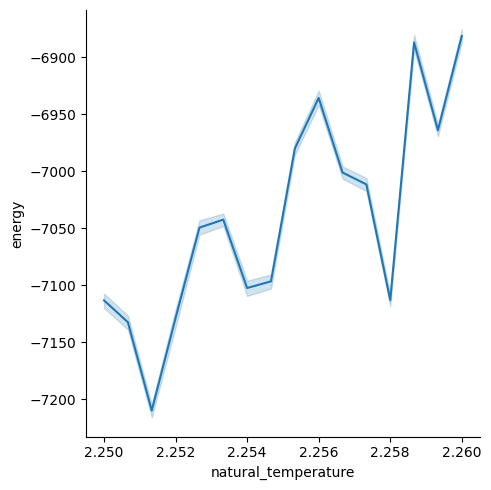

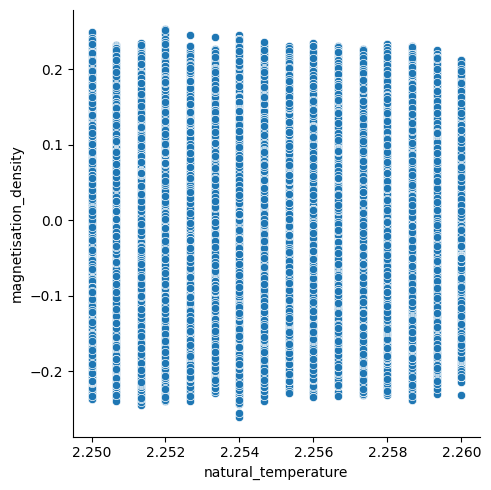

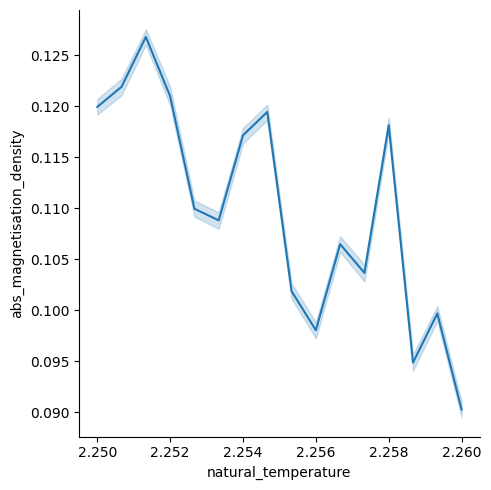

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

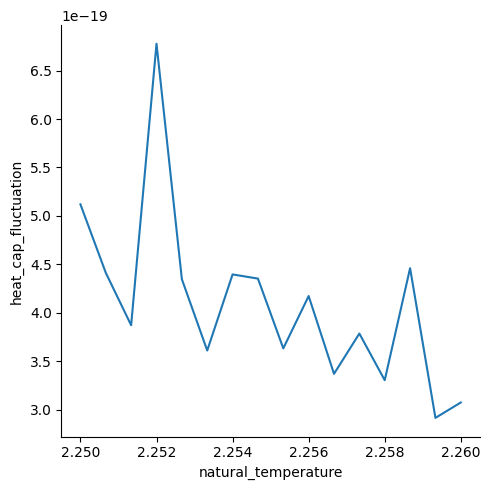

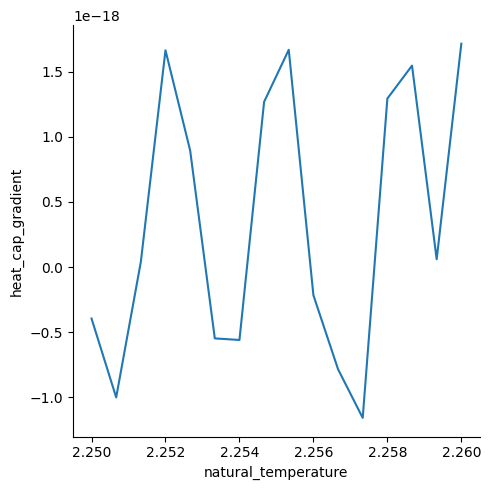

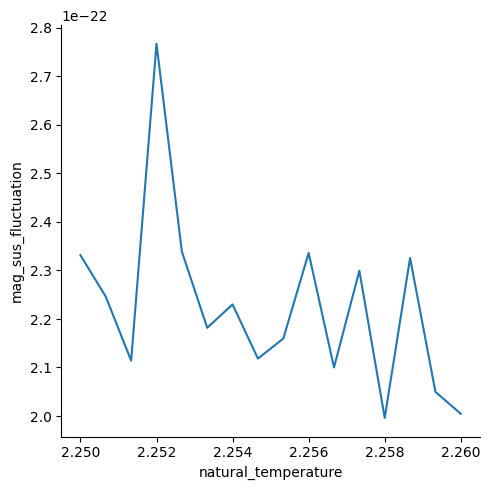

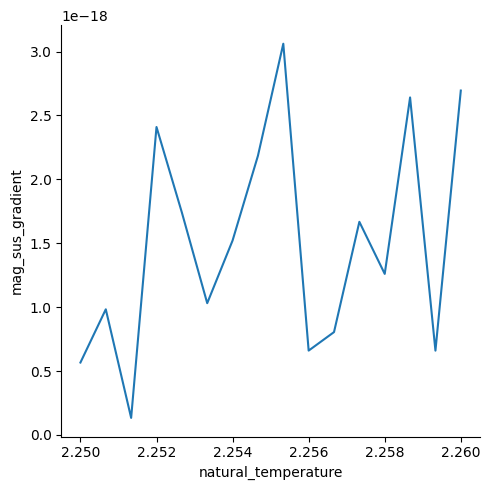

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

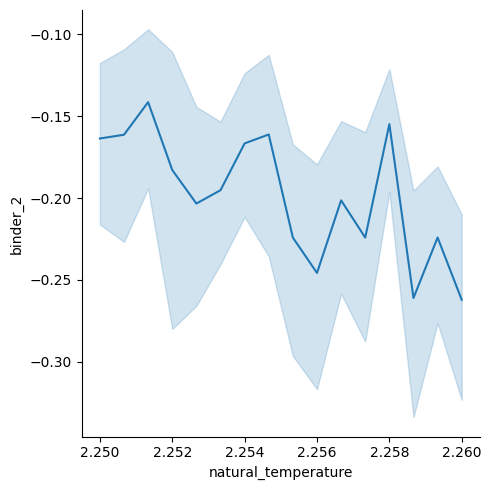

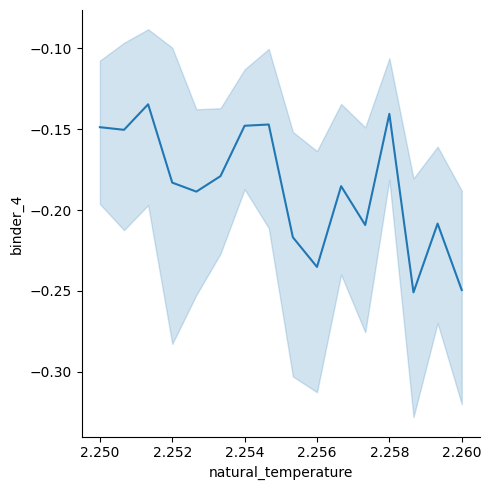

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )